[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5818
[LightGBM] [Info] Number of data points in the train set: 1523, number of used features: 30
[LightGBM] [Info] Start training from score -37.177938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

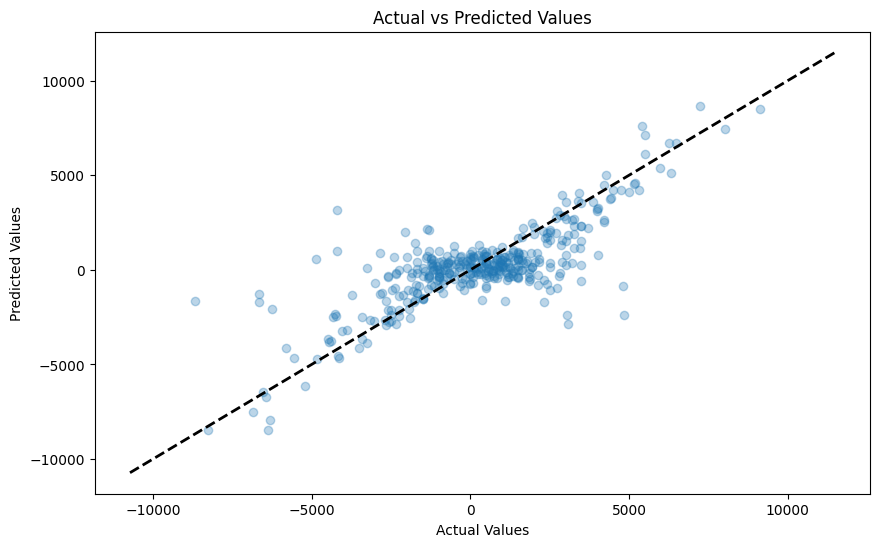

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from scipy import stats
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리
data = pd.read_csv('data/bsmax_0_1.csv', delimiter='\t')
data = data.dropna()  # 결측값 제거
data = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]  # 이상값 제거

data_processed = data.drop(columns=['ymd', 'rtn'])
X = data_processed
y = data['rtn']

# 특성 공학
# 여기서는 간단한 예시로 특성을 추가하지만, 도메인 지식을 활용하여 더 유용한 특성을 추가할 수 있습니다.
important_features = [0, 1, 2, 3, 4]  # 중요 특성 인덱스 예시
data['new_feature1'] = data.iloc[:, important_features[0]] * data.iloc[:, important_features[1]]
data['new_feature2'] = data.iloc[:, important_features[2]] ** 2
data['new_feature3'] = data.iloc[:, important_features[3]] / (data.iloc[:, important_features[4]] + 1)  # 0으로 나누는 것 방지

# 데이터 전처리 및 스케일링
data_processed = data.drop(columns=['ymd', 'rtn'])
X = data_processed
y = data['rtn']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 개별 모델 정의 및 하이퍼파라미터 튜닝
xgb_model = XGBRegressor(colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.8, random_state=42)
lgb_model = LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=1.0, random_state=42)
cat_model = CatBoostRegressor(iterations=200, learning_rate=0.05, depth=5, subsample=0.8, verbose=0, random_state=42)

# Stacking Ensemble 모델 정의
stacking_model = StackingRegressor(
    estimators=[('xgb', xgb_model), ('lgb', lgb_model), ('cat', cat_model)],
    final_estimator=RandomForestRegressor(n_estimators=100, random_state=42)
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 학습 데이터 성능 평가
y_train_pred = stacking_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
print(f'Stacking Ensemble Train Mean Squared Error: {mse_train}')
print(f'Stacking Ensemble Train R² Score: {r2_train}')

# 테스트 데이터 성능 평가
y_pred_stacking = stacking_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_stacking)
r2_test = r2_score(y_test, y_pred_stacking)
print(f'Stacking Ensemble Test Mean Squared Error: {mse_test}')
print(f'Stacking Ensemble Test R² Score: {r2_test}')

# 교차 검증 성능 평가
cv_scores = cross_val_score(stacking_model, X_scaled, y, cv=5, scoring='r2')
print(f'Cross-Validated R² Scores: {cv_scores}')
print(f'Average Cross-Validated R² Score: {np.mean(cv_scores)}')

# 실제 값과 예측 값의 분포 비교
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_stacking, alpha=0.3)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.show()
